Import relevent packages

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.preprocessing import image
import time

Using TensorFlow backend.


In [8]:
% matplotlib inline

# Convolution Operation


A discrete convolution operation involves dragging a *mask*, also known as a *kernel* over some data (i.e. image). The mask is typically small, for instance a 3x3 matrix, while the data is large: think image size. By putting the convolution mask over a single pixel in the image, one can compute the result by simple elementiwise multiplication and addition. For 1D this takes the following form

In [49]:
from numpy import convolve

# 1D convolution
a = [1,2,2,2,2,3,4,1,2,3,4,1,2,2,2,3,2] # data vector
b = [1,1,1] # convolution kernel

print(convolve(a,b)) # element i is the sum of i-1,i and i+1

[1 3 5 6 6 7 9 8 7 6 9 8 7 5 6 7 7 5 2]
17
19


In [6]:
b = [-1,0,1]
print(convolve(a,b)) # element i is the difference between element i+1 and i-1

[-1 -2 -1  0  0 -1 -2  2  2 -2 -2  2  2 -1  0 -1  0  3  2]


One can see that this particular kernel gives an approximation to the derivative. In fact it is equal to [central difference](http://mathworld.wolfram.com/CentralDifference.html) for a step size of 1/2.

Note that it is not obvious what to do at the boundary of the domain since at index i=0, we don't have avilable any value for i-1. Popular choices are to treat these values as 0, use the nearest boundary or use from the other boundary (periodic). Other choices are to simply don't compute for these values of i which means that the output vector will be smaller than the input vector.

### 2D convolution

![Convolution operation](./images/convolution.jpg)

2D convoltuion creates a 2D kernel to drag across the data.

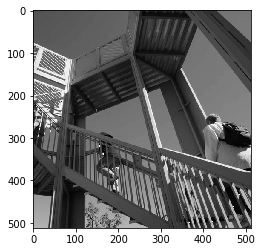

In [12]:
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from scipy.misc import ascent

img = ascent()
plt.imshow(img, cmap='gray')
plt.show()

[[ 0.11111111  0.11111111  0.11111111]
 [ 0.11111111  0.11111111  0.11111111]
 [ 0.11111111  0.11111111  0.11111111]]


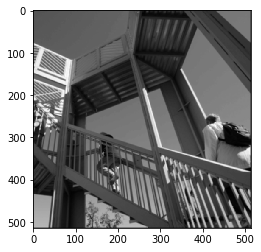

In [44]:
average = np.ones((3,3))/9 # create an "averaging mask" of size 3x3
print(average)
blurred_image = convolve2d(img, average)
plt.imshow(blurred_image, cmap='gray')
plt.show()

[[-1, 0, 1]]


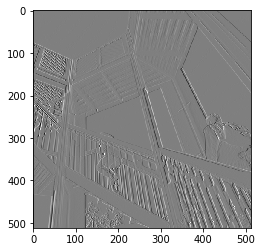

In [30]:
dI_dx = [[-1, 0, 1]] # create a [3,1] mask that approximates the x-derivative
print(dI_dx)
dx_img = convolve2d(img, dI_dx)
plt.imshow(dx_img, cmap='gray')
plt.show()

This particular map is usefull for detecting sharp intensity changes in the x-direction of the image: that is vertical edges. Other convolution operations include finding the y-derivative which is great for detecting horiztonal edges

[[-1], [0], [1]]


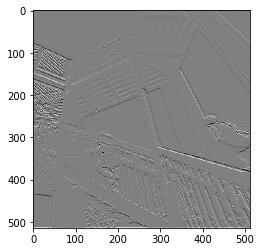

In [32]:
dI_dy = [[-1], [0], [1]] # create a [1,3] mask that approximates the y-derivative
print(dI_dy)
dy_img = convolve2d(img, dI_dy)
plt.imshow(dy_img, cmap='gray')
plt.show()

Convolution operations are used extensively in image processing. They prove indispensible for feature detection (edges, shapes etc) and enhancement (noise removal, edge sharpening). Traditional computer vision almost always started with mulitple convolution operations followed by extracting shapes and forms or other postprocessing.

Traditionally: a handful (3-10) of these filters have been crafted by a human engineer for the task at hand. We will now use Convolutional Neural Network to allow for a machine learning algorithm to design these filters for us and we will only need to specify how many we want.

# Maxpooling

Max pooling is mostly used to contain the data size. During a convolution layer, we generate multiple convolution kernels which each generate a full resolution image. If your original image was (128,128) pixels and we apply 40 filters to this, then we now have 40 (128,128) images as input after our first layer, multiplying the datasize by manyfold. Max pooling allow us to constrain this size while still keeping relevant features. A simple 2x2 max pooling filter will keep the maximum value of each (2x2) block of the dataset, effectively quartering the data size.

![Max pooling](./images/maxpool.png)

The trick is to balance convolution layer which tend to grow the data size and maxpooling layers which shrink their size so that we are able to maintain the features we want while still maintaining reasonable computational speed and don't suffer from low variance or large bias.

## A typical CNN structure

![Full structure of a CNN](./images/cnn.jpg)

The typical structure of a convolutional neural network. During convolution layers, we add multiple convolution filters and grow the data set. During max pooling layers we shrink the size by only keeping the maximum from a small region. The final stage of a CNN is a regular ANN. We move away from image-representation of the data and store it all in a simple vector by "flattening" the data. After this, we create one or more fully connected layers and also train these weights.

The weights that are to be trained are the convolution filters. We specify manually the number and size of such filters that we want, but leave their weights to be optimized at the learning stage. Max pooling layers are deterministic and have no weights to be optimized.

### A simple example

If we consider the input image from above along with the three convolution kernels

$$ w^{(1)}=\frac{1}{9}\left[\begin{array}{ccc}1&1&1\\1&1&1\\1&1&1\end{array}\right],\quad
   w^{(2)}=           \left[\begin{array}{ccc}0&0&0\\-1&0&1\\0&0&0\end{array}\right],\quad
   w^{(3)}=           \left[\begin{array}{ccc}0&1&0\\0&0&0\\0&-1&0\end{array}\right] $$
   
then these may form a single convolution layer. It takes as input a 2-dimensional input image of size, say 128x128 and outputs three images of size 128x128. We may intepret this as three seperate images or simply as a (128,128,3) data volume.

### Why convolution?

With ANN we flatten the image data into a single vector. An $n\times m$ image consist of $nm$ features. This means that our data dimension is $nm$. However, from intuition, we expect that a (grayscale) image is an inherently 2-dimensional object. The spatial connectivity has been lost during image flattening and the trained network is sensitive to translating the image just a single pixel in one direction since this will use completely different neurons.

Convolution allow us to reclaim this spatial dependence and treat the image as it is, a truly 2-dimensional dataset. This allows the computational complexity to increase slower with increasing image size as well as preserve translation invariance more easily.

# Activation

As per usual, we will use an activation function to break linearity. In practice, the rectified linear unit (relu) has given remarkably good results. 

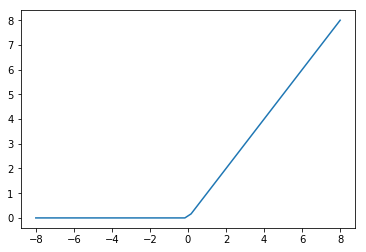

In [45]:
def relu(z):
    return np.maximum(z,0)

z = np.linspace(-8,8)
plt.plot(z, relu(z))
plt.show()

## A small manual CNN

In [58]:
# load input image
img = ascent()
img = img[::4,::4] # downsample image from a 512 x 512 image to a 128x128

# manually define the convolution kernels (these kernels will usually be decided during training)
w1 = np.ones((3,3))/9
w2 = [[0,0,0],[-1,0,1],[0,0,0]]
w3 = [[0,1,0],[0,0,0],[0,-1,0]]

# do the convolution operations to generate a z *volume*, or 3 hidden images
z1 = np.zeros((128,128,3))
z1[:,:,0] = relu( convolve2d(img, w1, mode='same') )
z1[:,:,1] = relu( convolve2d(img, w2, mode='same') ) # mode='same' treats outside values as zero
z1[:,:,2] = relu( convolve2d(img, w3, mode='same') ) # and ensures output size equal to img size

# max pooling of size (3x3) to reduce data size
z2 = np.zeros((64,64,3))
for i in range(0,128,2):
    for j in range(0,128,2): # stride of 2
        i0 = max(0,  i-1)
        i1 = min(128,i+2) # take care of boundary cases, [i0:i1] will be 3 entries from the image
        j0 = max(0,  j-1)
        j1 = min(128,j+2)
        z2[i//2, j//2, 0] = np.max(z1[i0:i1, j0:j1, 0])
        z2[i//2, j//2, 1] = np.max(z1[i0:i1, j0:j1, 1])
        z2[i//2, j//2, 2] = np.max(z1[i0:i1, j0:j1, 2])



Notice that the max-pooling in this case does not have matching size and stride. It computes the maximum of a 3x3 mask centered around every second pixel. This creates overlap and you will typically try and use this as this reduces the infomation loss, while still reducing data size.

# A keras implementation of a CNN

Building Convolutional Neural Network in keras is actually easier than building the artificial neural network. We use MNIST database of hand-written digits

In [89]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.datasets import mnist
from sklearn.preprocessing import LabelBinarizer

# create preprocessor
categorical_transform = LabelBinarizer().fit(np.arange(10))

# Read the dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Transform the data to usable form (Convolution layers expect 4d tensor as input [n_images, width, height, colors])
X  = X_train.reshape(60000,28,28,1) 
Xt = X_test.reshape( 10000,28,28,1)
y  = categorical_transform.transform(y_train)
yt = categorical_transform.transform(y_test)


# Initialising the CNN
model = Sequential()

# Step 1 - Convolution (32 filters / feature detectors each having 3x3 dimension)
model.add(Conv2D(32, (3, 3), input_shape = (28, 28,1), activation = 'relu'))

# Step 2 - Pooling (3x3 filter)
model.add(MaxPooling2D(pool_size = (3,3), strides=2))

# Adding a second convolutional layer (32 filters / feature detectors each having 3x3 dimension)
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (3,3), strides=7))

# Step 3 - Flattening (Flatten the previous layers into a one dimensional array to be fed to a ANN)
model.add(Flatten())

# Step 4 - Full connection
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units = 10, activation = 'softmax'))

# Compiling the CNN
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])


We will now train the network. The below code may take long (several minutes) to run, depending on your hardware.

In [79]:
# Training the CNN
model.fit(X,y,
         epochs=5,
         batch_size=100,
         validation_data=(Xt,yt))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 31s 523us/step - loss: 2.1156 - acc: 0.7868 - val_loss: 0.1834 - val_acc: 0.9423
Epoch 2/5
60000/60000 [==============================] - 35s 578us/step - loss: 0.1564 - acc: 0.9514 - val_loss: 0.1258 - val_acc: 0.9599
Epoch 3/5
60000/60000 [==============================] - 33s 542us/step - loss: 0.1139 - acc: 0.9646 - val_loss: 0.1008 - val_acc: 0.9671
Epoch 4/5
60000/60000 [==============================] - 35s 590us/step - loss: 0.0922 - acc: 0.9710 - val_loss: 0.0987 - val_acc: 0.9696
Epoch 5/5
60000/60000 [==============================] - 34s 567us/step - loss: 0.0808 - acc: 0.9737 - val_loss: 0.1105 - val_acc: 0.9649


For inspiration purposes it might be worthwile to check the [MNIST dataset hall of fame](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354) and compare the accuracy that you are getting.

As always in machine learning: there are two main ways to improve your predictions: more advanced models, or more training data. To create a more advanced model one simply adds more layers, or increase the size of the layers you have. This is not always going to give you better predictions as with too many weights to tune, your model becomes prone to overfitting. In this case you will need more data, and there is a clever trick that one can use with image input known as *data augmentation*

## Data augmentation

We can slightly modify our image database to create new images without having to manually tag these by hand. The idea is that if you take an image which have been identified by a human as a 0, then moving this image one pixel to the right (filling the now open left edge by cloning the old left edge), then this will be a new unseen image as far as our model is concerned and training on this image will increase model accuracy, while we can re-use the tag that we already have for 0 human work. There exist a number of such simple transformations that we can apply to images to increase our database.

Keras have built-in support for this data augmentation. Examples of transofmations are
* rescaling image (brightness intensity)
* flipping (vertically or horizontally)
* shift x pixels (width or height direction)
* zoom
* shear

The size of these transformations are always multiplied by a random amount. If one for instance specifies
`width_shift_range=.2`, then this will move the image a random amount up to a maximum of 20% of the total image width. Combining this random effect with permutations of multiple effects creates and almost endless supply of new images to train from. One should note however that these images can be considered of lower quality since they contain *some* new information, but not as much as a new hand-drawn digit created, and classified, by a human contributer.

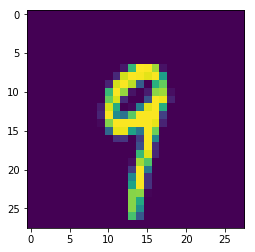

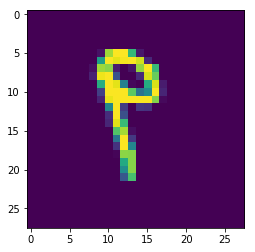

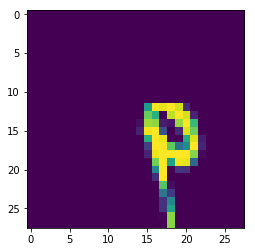

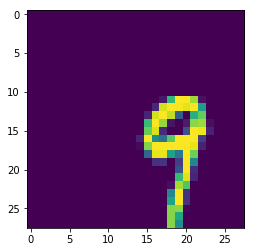

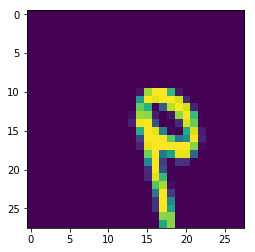

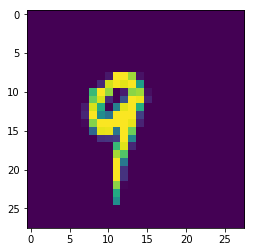

In [86]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# create a generator to create more training images for us
generator = ImageDataGenerator(horizontal_flip=True,
                               width_shift_range=.2,
                               height_shift_range=.2,
                               zoom_range=[1,1.2])

# start with a single image
one_image = X_train[600,:,:]
plt.imshow(one_image)
plt.show()


# generate new images based on this image
k = 0
for x,y in generator.flow(X_train[600,:,:].reshape(1,28,28,1),y_train[600].reshape(1,1)):
    plt.imshow(x[0,:,:,0])
    plt.show()
    
    # the 'flow' method will create an endless loop, so we have to manually break this at some point
    k += 1
    if k>4:
        break


Of course, `horizontal_flip` makes no sense for digit recognition and will in fact hurt our training method more than it helps, but the example shows what kind of images you get. The slightly odd slicing one has to perform comes from the fact that we in the above example insisted on having just a single image as a sample base. A large-scale implementation of this technique looks like this

In [91]:
for x0,y0 in generator.flow(X,y, batch_size=512):
    print(x0.shape) # this creates 512 new images which are random permutations of randomly chosen images
    print(y0.shape) # the labels are copied from the source image (remember that these are one-hot encoded)
    break;          # flow() will continually produce new images until a break statement is issued

(512, 28, 28, 1)
(512, 10)


Apply different kinds of transformations to generate variations if input images for training the network. The image dataset can be downloaded from https://www.dropbox.com/s/5dx3zcoxgytihlj/cats_dogs.zip?dl=0

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
#Load the images from the directory training_set having two sub-folders cats and dogs
training_set = train_datagen.flow_from_directory('../../datasets/cats_dogs/training_set',
                                                 target_size = (64, 64), batch_size = 32, class_mode = 'binary')
#Load the images from the directory test_set having two sub-folders cats and dogs
test_set = test_datagen.flow_from_directory('../../datasets/cats_dogs/test_set', 
                                            target_size = (64, 64), batch_size = 32, class_mode = 'binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Train and save the model. This will take some time (6 hours on my desktop computer) so you can relax.

In [ ]:
model.fit_generator(training_set, steps_per_epoch = 8000, epochs = 25, validation_data = test_set, validation_steps = 2000)
print("Training complete")
model.save('CNN_Cat_Dog_trained_model.h5',overwrite=True)
print("Trained Model saved")
end_time=time.time()
print("Total time ",end_time-start_time)

Epoch 1/25
4876/8000 [=================>............] - ETA: 296s - loss: 0.4597 - acc: 0.7739

I am also including a trained model "CNN_Cat_Dog.h5" that you can generate by running the previous cell. You can use it to classify cats and dogs. Load the model and use it for making classifications.

In [ ]:
classifier = load_model('CNN_Cat_Dog.h5')

In [ ]:
test_image = image.load_img('../../datasets/cats_dogs/single_prediction/cat.1.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
if result[0][0] == 1:
    prediction = 'dog'
else:
    prediction = 'cat'
print("The image is that of a ",prediction) 